# Electoral Physics 

### Packages

In [1]:
# Data Management 
using DataFrames, DataFramesMeta
using DrWatson

# Statistics
using Random
using Distributions
using StatsBase

# Graphs 
using LightGraphs, SimpleWeightedGraphs
using GraphPlot
 #using Graphs

# Modelling
using Agents
include("./ElectoralPhysics.jl")

# Data Visualization
using Plots
using AgentsPlots
using PlotThemes

# Python
# ENV["PYTHON"] = "path/to/python"
# Pkg.build("PyCall")
using PyCall
using PyPlot
nx = pyimport("networkx")
np = pyimport("numpy")
nw = pyimport("netwulf");

### Agent Type 

In [2]:
# Voter Definition
mutable struct Voter <: AbstractAgent
    id::Int64             # ∈ ℕ
    pos::Int64            # ∈ ℕ
    candidacy::Bool       # ∈ 𝔹
    score::Float64        # \in \bbR
end

### Micro-Dynamics

In [3]:
function vote!(agent,model)
    nvotes = rand(1:model.properties[:M])
    for vote in 1:nvotes
        target = choose_candidate!(agent, model)
        add_edge!(model.space.graph, agent.pos, target.pos, 1/nvotes)
    end
end

function choose_candidate!(agent, model)
    target = random_agent(model)
    while target.candidacy == false || target.id == agent.id
        target = random_agent(model)
    end
    return target
end

function update_score_indegree!(model)
    for agent in allagents(model)
        agent.score = agent.score + 10*indegree_centrality(model.space.graph)[agent.id]
    end
end

function update_score_flow!(model)
    for agent in allagents(model)
        if agent.candidacy == true
            for inneighbor in node_neighbors(agent, model; neighbor_type=:in)
                agent_inneighbor = get_node_agents(inneighbor, model)[1]
                if agent_inneighbor.candidacy == false
                    agent.score = agent.score + agent_inneighbor.score * LightGraphs.weights(model.space.graph)[agent.pos, agent_inneighbor.pos]
                end
            end
        end
    end
end

function update_score_pagerank!(model, α, n, ϵ)
    for agent in allagents(model)
        agent.score = 1 + 10*pagerank(model.space.graph, α, n, ϵ)[agent.id]
    end
end

# Individual Dynamics 
function agent_step!(agent, model)
    vote!(agent, model)
end;

### Models

In [4]:
# Voter Model Initialization
function init_model_voters(N::Int64, M::Int64, K::Int64)
       
    properties = @dict(N, M, K)
    
    # Create Directed Weighted Graph
    space = GraphSpace(SimpleWeightedDiGraph(N)) 
    model_voters = ABM(Voter, space; properties = properties)
    
    for id in 1:N
        pos = id
        score = 1.0
        if id <= M
            candidacy = true
            add_agent!(pos, model_voters, candidacy, score)
        else
            candidacy = false
            add_agent!(pos, model_voters, candidacy, score)
        end
    end
    return model_voters
end;

# Candidate Model Initialization
function init_model_candidates(model_voters::AgentBasedModel{Voter,GraphSpace{SimpleWeightedDiGraph{Int64,Float64}},typeof(fastest),Dict{Symbol,Int64}}, 
                                M::Int64, K::Int64)
       
    properties = @dict(M, K)
    
    # Induce Subgraph
    graph, vertex_map = induced_subgraph(model_voters.space.graph, 1:M)
    space = GraphSpace(graph)
    model_candidates = ABM(Voter, space; properties = properties)
    
    k = 0
    for voter in allagents(model_voters)
        if voter.candidacy == true
            add_agent!(voter.pos, model_candidates, voter.candidacy, voter.score)
        end
    end
    
    for agent in allagents(model_candidates)
    agent.id = agent.pos
    end
    
    return model_candidates
end;

### Parameters

In [5]:
# Create population of voters 
N = 800

# Create subpopulation of candidates
M = 80;

# Create subpopulation of elected
K = 20;

# Initialize number of steps
nsteps = 1;

α = 0.85
n = 500 
ϵ = 1e-6;

### Simulation

In [6]:
# Seed Selection
Random.seed!(1234);

# Model Instantiation 
model_voters = init_model_voters(N, M, K)

# Data Collection
data = run!(model_voters, agent_step!, nsteps);

update_score_indegree!(model_voters)

sort!(DataFrame(allagents(model_voters)), :score, rev = true)

,id,pos,candidacy,score
,Int64,Int64,Bool,Float64
1,9,9,1,5.16771
2,43,43,1,5.05507
3,71,71,1,5.00501
4,75,75,1,4.95494
5,22,22,1,4.95494
6,57,57,1,4.95494
7,52,52,1,4.95494
8,67,67,1,4.94243
9,10,10,1,4.92991


### Visualization 

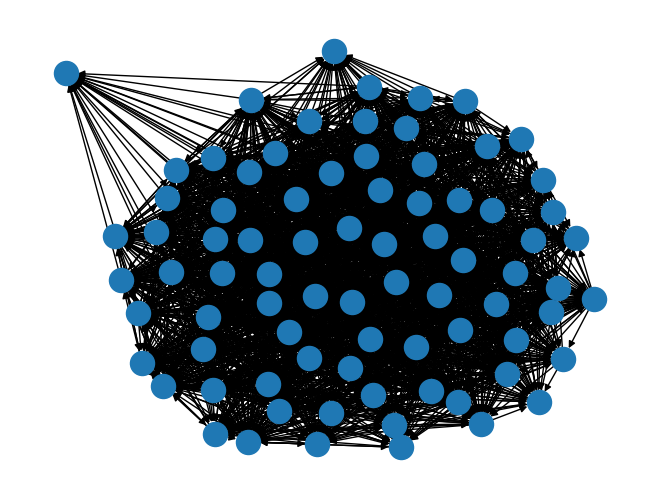

In [8]:
model_candidates = init_model_candidates(model_voters, M, K)

G = model_candidates.space.graph
H = ElectoralPhysics.LightGraphs_to_NetworkX(G);
H = nx.convert_node_labels_to_integers(H, first_label=1);
nx.write_graphml(H, "random_graph_flow.graphml")
#visualize(G)
nx.draw(H)